In [896]:
import networkx as nx
from matplotlib import pyplot as plt

In [897]:
g = nx.grid_2d_graph(25,25)

In [898]:
e = g.edges()
for edge in e:
    g.remove_edge(u = edge[0],v=edge[1])

In [899]:
g.add_edge((0,0),(0,1))
g.add_edge((0,1),(1,1))
g.add_edge((1,1),(2,1))
g.add_edge((2,1),(2,2))
g.add_edge((1,1),(1,2))
g.add_edge((1,2),(2,2))

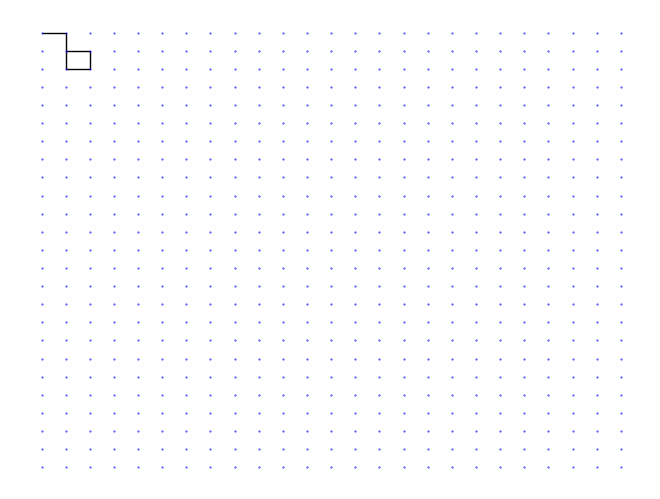

In [900]:
pos = dict(((x,y), (y,-x)) for x,y in g.nodes())
nx.draw(g, pos, with_labels=False, node_color='blue',node_size=0.15)

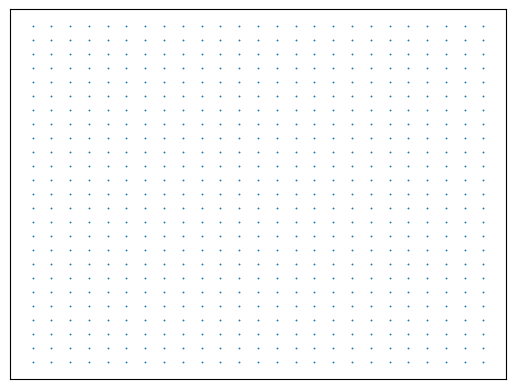

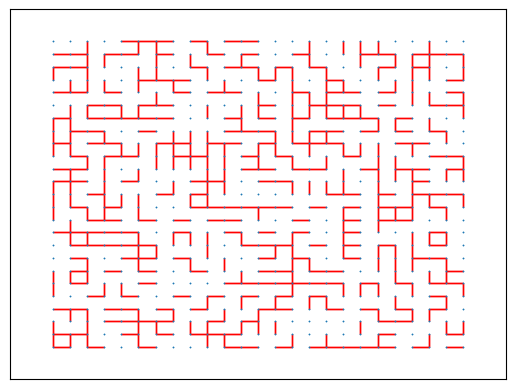

In [917]:
"""
111901030
Mayank Singla
Coding Assignment 2 - Q5
"""

# %%
from networkx import grid_2d_graph, draw_networkx_nodes, draw_networkx_edges
from random import random
import matplotlib.pyplot as plt
from queue import Queue


def handleError(method):
    """
    Decorator Factory function.
    Returns a decorator that normally calls the method of a class by forwarding all its arguments to the method.
    It surrounds the method calling in try-except block to handle errors gracefully.
    """

    def decorator(ref, *args, **kwargs):
        """
        Decorator function that surrounds the method of a class in try-except block and call the methods and handles error gracefully.
        """
        try:
            # Return the same value as that of the method if any
            return method(ref, *args, **kwargs)
        except Exception as err:
            print(type(err))
            print(err)

    return decorator


class Lattice:
    """
    lattice class to represent a `n x n` grid graph
    """

    @handleError
    def _drawNodes(self, pos, node_size, linewidths):
        """
        Draws nodes on the lattice graph given the position of nodes, the size of each node and the linewidth of each node
        """
        draw_networkx_nodes(
            G=self.gr, pos=pos, node_size=node_size, linewidths=linewidths
        )

    @handleError
    def _drawEdges(self, pos, edgelist, edge_color, width=1):
        """
        Draws edges on the lattice graph given the position of nodes, the edge list and the color of edges
        """
        draw_networkx_edges(
            G=self.gr, pos=pos, edgelist=edgelist, edge_color=edge_color, width=width
        )

    @handleError
    def __init__(self, n):
        """
        Constructor of the Lattice class.
        """
        if n < 0:
            raise Exception("n must be a positive integer")
        self.n = n  # The dimension of the lattice
        self.gr = grid_2d_graph(n, n)  # The lattice graph
        self.nodePos = {}  # The position of nodes in the lattice graph
        self.edgeList = {}  # The adjacency list of the lattice graph
        for x, y in self.gr.nodes():
            # The position of nodes in the lattice graph in matrix indexing
            self.nodePos[(x, y)] = (y, -x)
            # Initializing the adjacency list of the lattice graph
            self.edgeList[(x, y)] = []

    @handleError
    def _getLatticeEdgeList(self):
        """
        Returns the lattice edge list in the required format
        """
        edgeList = []  # Building the edge list in the required format
        for x, l in self.edgeList.items():
            for y in l:
                edgeList.append((x, y))
        return edgeList

    @handleError
    def show(self, shouldPlot=True):
        """
        Displays the lattice graph.
        """
        # Draw the nodes in the lattice graph
        self._drawNodes(self.nodePos, node_size=1, linewidths=0.25)
        # Draw the edges in the lattice graph
        self._drawEdges(self.nodePos, self._getLatticeEdgeList(), "r")
        if shouldPlot:
            # Plot the lattice graph
            plt.show()

    @handleError
    def percolate(self, p):
        """
        Percolates the lattice graph with probability p, using bond percolation.
        """
        # Clearing the adjacency list of the lattice graph
        for node in self.gr.nodes():
            self.edgeList[node] = []

        def _isProbable():
            """
            Returns True if the random number generated is less than the probability p.
            """
            return random() < p

        def try_add_edge_right(i, j):
            """
            Adds an edge between the node at position (i, j) and the node at position (i, j+1) with probability p, if the node at position (i, j+1) is in the lattice graph.
            """
            if j < self.n - 1 and _isProbable():
                self.edgeList[(i, j)].append((i, j + 1))
                self.edgeList[(i, j + 1)].append((i, j))

        def try_add_edge_down(i, j):
            """
            Adds an edge between the node at position (i, j) and the node at position (i+1, j) with probability p, if the node at position (i+1, j) is in the lattice graph.
            """
            if i < self.n - 1 and _isProbable():
                self.edgeList[(i, j)].append((i + 1, j))
                self.edgeList[(i + 1, j)].append((i, j))

        # Iterate over the nodes in the lattice graph
        for i in range(self.n):
            for j in range(self.n):
                # Adding the edges between the nodes in the lattice graph
                if i < self.n - 1 and j < self.n - 1:
                    try_add_edge_right(i, j)
                    try_add_edge_down(i, j)
                elif i < self.n - 1:
                    try_add_edge_down(i, j)
                elif j < self.n - 1:
                    try_add_edge_right(i, j)

    @handleError
    def _getPathEdges(self, root, node, parent):
        """
        Returns the list of edges in the path from the root to the node.
        """
        pathEdges = []
        while node != root:
            pathEdges.append((node, parent[node]))
            node = parent[node]  # Backtracking to the root
        return pathEdges

    @handleError
    def _bfs(self, sv, onlyCheck=True):
        """
        Performs breadth first search on the lattice graph starting from the node sv.
        if onlyCheck is True, it only checks if the lattice graph is percolating or not.
        if onlyCheck is False, it returns
            -   the list of edges in the path from the starting node to the farthest node if the lattice graph is not percolating
            -   the list of edges in the shortest path from u to the bottom-most layer if the lattice graph is percolating
        """
        # visited is a set of nodes visited and parent is a dictionary of parent nodes
        visited, parent = set(), {}
        q = Queue()
        q.put((sv, 0))  # Enqueue the starting node
        visited.add(sv)  # Mark the starting node as visited
        parent[sv] = None  # Set the parent of the starting node as None
        farthestNode = sv  # The farthest node from the starting vertex
        # The distance of the farthest node from the starting vertex
        farthestDistance = 0
        while not q.empty():  # While the queue is not empty
            u, d = q.get()  # Dequeue the node
            if d > farthestDistance:  # Update the farthest node and its distance
                farthestNode = u
                farthestDistance = d

            # Flag to check if the lattice graph is percolating or not
            isPercolating = False

            for v in self.edgeList[u]:  # For each node v adjacent to u
                if not v in visited:  # If v is not visited
                    q.put((v, d + 1))  # Enqueue v and incrementing the distance
                    visited.add(v)  # Mark v as visited
                    parent[v] = u  # Set the parent of v as u
                    if v[0] == self.n - 1:  # If v is in the bottom-most layer
                        # The lattice graph is percolating
                        isPercolating = True
                        if onlyCheck:
                            return True
                        else:
                            farthestNode = v  # Mark v as the farthest node
                            break

            if isPercolating:
                break

        if onlyCheck:
            # The lattice graph is not percolating and onlyCheck is True
            return False

        return self._getPathEdges(sv, farthestNode, parent)

    @handleError
    def existsTopDownPath(self):
        """
        Returns True if a path exists (along the open bonds) from the top-most layer to the bottom-most layer of the grid graph, returns False otherwise.
        """
        for j in range(self.n):
            # Executing BFS on the lattice graph from each top-most layer node
            # If a path exists from the top-most layer to the bottom-most layer of the grid graph
            if self._bfs((0, j)):
                return True
        return False

    @handleError
    def showPaths(self):
        """
        For every node u in the top-most layer, does either the following:
            -   If there is no path from u to nodes in the bottom-most layer, display the largest shortest path that originates at u
            -   Otherwise, display the shortest path from u to the bottom-most layer.
        """
        plt.figure(figsize=(10, 7.5))  # Setting the figure size
        self.show(shouldPlot=False)  # Plotting the lattice graph
        for j in range(self.n):
            # Executing BFS on the lattice graph from each top-most layer node
            # Getting the list of edges on executing BFS from this node
            pathList = self._bfs((0, j), onlyCheck=False)
            # Draw the edges in the lattice graph
            self._drawEdges(self.nodePos, pathList, "g", width=2.5)
        # Show the lattice graph
        plt.show()


if __name__ == "__main__":
    # Sample Test Case 1
    l = Lattice(25)
    l.show()

    # Sample Test Case 2
    l = Lattice(25)
    l.percolate(0.4)
    l.show()
